# Energy Production Forecasting — Problem Statement

## Objective
The objective of this project is to **predict hourly energy production** using historical production data and time-based contextual features.

## Target Variable
- **`Production`**: Continuous numerical value representing energy produced during a specific hour.

## Nature of the Data
- Tabular **time-series regression** dataset  
- Each row corresponds to energy production at a given timestamp  
- Contains both temporal features (date, hour, seasonality) and categorical context (energy source, season)

Because the data is time-dependent, it is treated as a **time-series problem**, and random shuffling is avoided to prevent data leakage.

## Real-World Relevance
Accurate energy production forecasting is essential for:
- grid stability and load balancing  
- energy capacity planning  
- efficient integration of renewable energy sources  

This project mirrors real-world forecasting challenges faced by energy operators.

## Evaluation Metric
- **RMSE (Root Mean Squared Error)** is used as the primary evaluation metric, as it penalizes large prediction errors and is well-suited for continuous energy output values.

## Project Goals
- Build a robust time-series regression pipeline  
- Compare baseline and machine learning models  
- Apply meaningful feature engineering  
- Use time-aware validation strategies  
- Analyze **where and why models fail**, not just overall accuracy  

## Methodology Overview
The modeling workflow followed in this project includes:
- chronological train, validation, and test splitting to respect temporal order  
- baseline model establishment for performance benchmarking  
- preprocessing pipelines to prevent data leakage  
- feature engineering using time-based and lag features  
- model comparison and controlled hyperparameter tuning  
- error and residual analysis to understand failure patterns and limitations  


---

# Phase 1 — Data Understanding & Sanity Checks

Before building any models, it is essential to understand the dataset, validate its integrity, and confirm that it is suitable for time-series regression. This phase focuses on data quality, temporal consistency, and basic exploratory analysis.

## Key Goals of This Phase
- verify that the data is clean and well-structured  
- confirm that the temporal ordering is correct  
- ensure the target variable is valid  
- identify basic temporal and seasonal patterns  
- avoid premature transformations or modeling decisions  

## Scope
In this phase:
- the data is **only inspected and visualized**
- no feature transformations are applied
- no models are trained
- all observations are documented to guide later phases


In [2]:
# import all libraries 
import sys
from pathlib import Path

ROOT = Path.cwd().parent  # notebooks -> project root
SRC = ROOT / "src"

if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

print("src path added:", SRC)

import energy_forecast
print("energy_forecast package imported successfully")

from energy_forecast.io import load_data


# data analysis-libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# scikit-learn models and validation functions
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# metrics
from sklearn.metrics import root_mean_squared_error


src path added: C:\ML\test_project\project-regression\src
energy_forecast package imported successfully


### *Data understading and sanity checks*

In [4]:
data = load_data("../data/Energy Production Dataset.csv", date_col="Date")

data.head()

,Date,Start_Hour,End_Hour,Source,Day_of_Year,Day_Name,Month_Name,Season,Production
0,2020-01-01,13,14,Solar,1,Wednesday,January,Winter,2179
1,2020-01-01,21,22,Wind,1,Wednesday,January,Winter,1228
2,2020-01-01,20,21,Wind,1,Wednesday,January,Winter,1268
3,2020-01-01,6,7,Wind,1,Wednesday,January,Winter,2293
4,2020-01-01,19,20,Wind,1,Wednesday,January,Winter,1181


#### Safety check after using `parse_dates` as it can silently coerce bad rows.

In [3]:
print("Invalid dates: ",data.Date.isna().sum())
print("Date range: ",data.Date.min(), "->", data.Date.max())

Invalid dates:  0
Date range:  2020-01-01 00:00:00 -> 2025-11-30 00:00:00


#### Analysing the data

In [7]:
print("shape: ",data.shape)
print("\ndtype:\n",data.dtypes)

shape:  (51864, 9)

dtype:
 Date           datetime64[ns]
Start_Hour              int64
End_Hour                int64
Source                 object
Day_of_Year             int64
Day_Name               object
Month_Name             object
Season                 object
Production              int64
dtype: object


In [5]:
# sorting data by time.
data = data.sort_values("Date").reset_index(drop=True)
data

,Date,Start_Hour,End_Hour,Source,Day_of_Year,Day_Name,Month_Name,Season,Production
0,2020-01-01,13,14,Solar,1,Wednesday,January,Winter,2179
1,2020-01-01,21,22,Wind,1,Wednesday,January,Winter,1228
2,2020-01-01,20,21,Wind,1,Wednesday,January,Winter,1268
3,2020-01-01,6,7,Wind,1,Wednesday,January,Winter,2293
4,2020-01-01,19,20,Wind,1,Wednesday,January,Winter,1181
...,...,...,...,...,...,...,...,...,...
51859,2025-11-30,13,14,Wind,334,Sunday,November,Fall,7474
51860,2025-11-30,9,10,Wind,334,Sunday,November,Fall,5092
51861,2025-11-30,7,8,Wind,334,Sunday,November,Fall,4625
51862,2025-11-30,1,2,Wind,334,Sunday,November,Fall,5081


#### confirming time ordering

In [6]:
data.Date.is_monotonic_increasing

True

#### To check time coverage. 

In [7]:
print("start date: ",data.Date.min())
print("end date: ",data.Date.max())
print("total rows: ",len(data))
print("unique dates: ",data.Date.nunique())

start date:  2020-01-01 00:00:00
end date:  2025-11-30 00:00:00
total rows:  51864
unique dates:  2161


### To analyse target column

In [8]:
data.Production.describe()

count    51864.000000
mean      6215.069933
std       3978.364965
min         58.000000
25%       3111.000000
50%       5372.000000
75%       8501.000000
max      23446.000000
Name: Production, dtype: float64

In [9]:
data.Production.info()

<class 'pandas.core.series.Series'>
RangeIndex: 51864 entries, 0 to 51863
Series name: Production
Non-Null Count  Dtype
--------------  -----
51864 non-null  int64
dtypes: int64(1)
memory usage: 405.3 KB


In [10]:
invalid_prod = (data.Production < 0).sum()
# energy production should not be negative.
print("invalid energy production data : ",invalid_prod)

invalid energy production data :  0


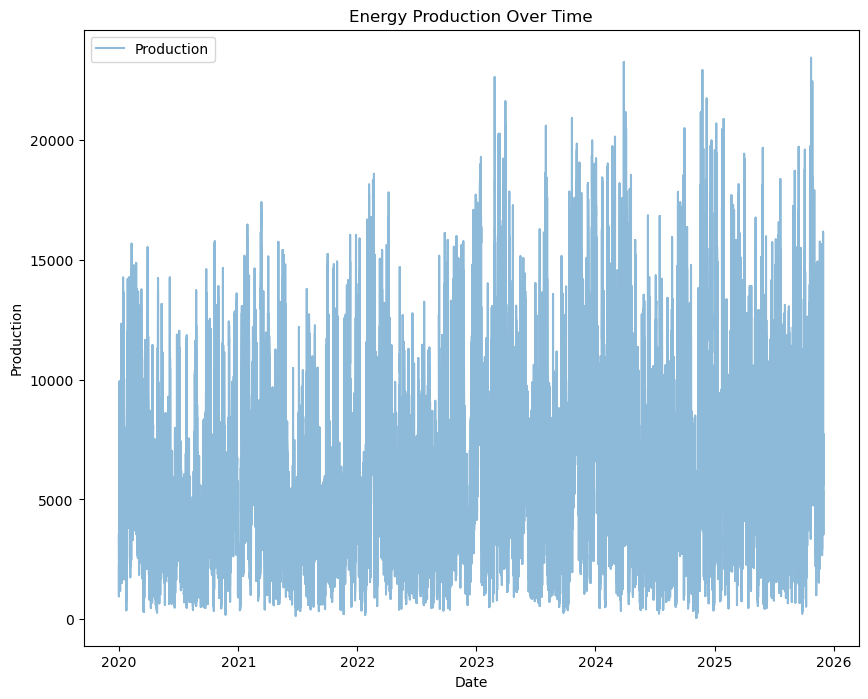

In [11]:
# to visualize target column.

fig, ax = plt.subplots(figsize =(10,8))
ax.plot(data.Date, data.Production, label="Production",alpha=0.5)

ax.set_title("Energy Production Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Production")
ax.legend()

plt.show()


negative_points = data[data.Production < 0]
ax.scatter(negative_points.Date,
           negative_points.Production,
           color="red",
           label="negative values",
           zorder=3
          );


Negative values in the target variable were checked, as energy production cannot be negative.  
Any such values are treated as potential data quality issues and are analyzed visually before deciding on corrective action in later stages.


### Histogram Of Production

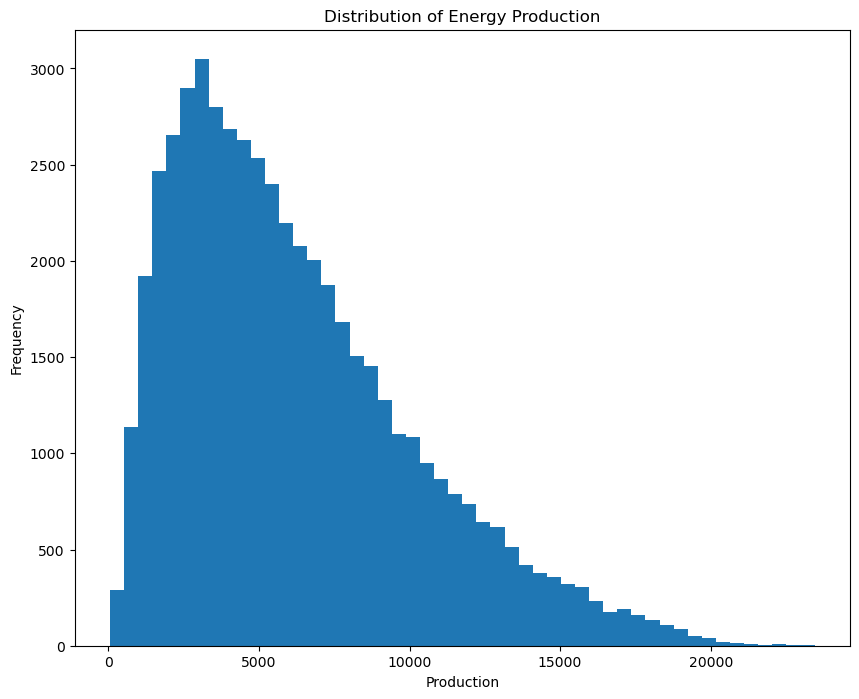

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.hist(data["Production"], bins=50)
ax.set_title("Distribution of Energy Production")
ax.set_xlabel("Production")
ax.set_ylabel("Frequency")

plt.show()


### Check for Hourly Pattern in the Data

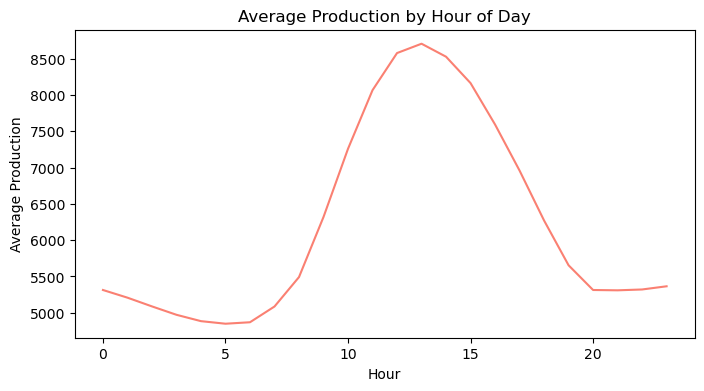

In [13]:
if "Start_Hour" in data.columns:
    hourly_avg = data.groupby("Start_Hour")["Production"].mean()

    plt.figure(figsize=(8,4))
    hourly_avg.plot(color="salmon")
    plt.title("Average Production by Hour of Day")
    plt.xlabel("Hour")
    plt.ylabel("Average Production")
    plt.show()

### Check for Seasonal/Categorical sanity

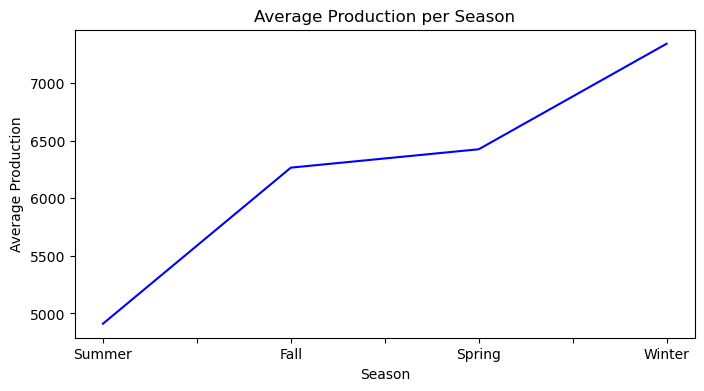

In [14]:
if "Season" in data.columns:
    seas_avg = data.groupby("Season")["Production"].mean().sort_values()

    plt.figure(figsize=(8,4))
    seas_avg.plot(color="blue")
    plt.title("Average Production per Season")
    plt.xlabel("Season")
    plt.ylabel("Average Production")
    plt.show()

## Phase 1 — Data Understanding & Sanity Checks (Summary)

In this phase, the dataset was explored and validated to ensure it is suitable for time-series regression modeling.

Key steps and findings:

- The dataset was successfully loaded and inspected for structure, data types, and completeness.
- The `Date` column was parsed as a datetime object and the data was sorted chronologically to preserve temporal order.
- Time integrity checks confirmed that the data is monotonically increasing in time, with no future-to-past leakage.
- The target variable (`Production`) was examined for validity:
  - No negative production values were found.
  - The distribution shows realistic variability with clear patterns.
- Basic exploratory analysis revealed meaningful temporal structure:
  - Clear hourly patterns in energy production.
  - Distinct differences in average production across seasons.
- No transformations or modeling decisions were applied at this stage; all observations were documented to inform later phases.

Overall, Phase 1 confirms that the **dataset is clean, temporally consistent, and well-suited for time-series regression**. The observed daily and seasonal patterns justify the use of time-aware splitting, lag features, and advanced validation strategies in subsequent phases.


---

# Phase 2 — Train / Validation / Test Strategy

## Why time-based splitting?
This is a time-series regression problem, so the data must be split **chronologically**.  
Random shuffling is avoided to prevent **data leakage**, where information from the future could influence training.
- Hyperparameter tuning via GridSearch or RandomizedSearch was intentionally avoided to prevent temporal leakage and to prioritize interpretability and methodological correctness.


## Split Plan
- **Train:** first 70% of the timeline  
- **Validation:** next 15%  
- **Test:** final 15%  

The test set remains untouched until the final evaluation.


In [15]:
# split data into train and validation sets. 
len_data = len(data)

train_split = int(0.70 * len_data)
valid_split = int((0.85) * len_data)

train_df = data.iloc[:train_split].copy()
valid_df = data.iloc[train_split:valid_split].copy()
test_df  = data.iloc[valid_split:].copy()

print("train:",len(train_df)," val:",len(valid_df), " test:",len(test_df)  )

train: 36304  val: 7780  test: 7780


-  Time ranges for each split

In [16]:
print("Train:", train_df["Date"].min(), "→", train_df["Date"].max())
print("Val  :", valid_df["Date"].min(),   "→", valid_df["Date"].max())
print("Test :", test_df["Date"].min(),  "→", test_df["Date"].max())


Train: 2020-01-01 00:00:00 → 2024-02-21 00:00:00
Val  : 2024-02-21 00:00:00 → 2025-01-10 00:00:00
Test : 2025-01-10 00:00:00 → 2025-11-30 00:00:00


- Check for row overlaps

In [17]:
assert train_df.index.max() < valid_df.index.min(), "train/val overlap detected!"
assert valid_df.index.max() < test_df.index.min(), "val/test overlap detected!"
print("no overlap detected")


no overlap detected


**Check for Target drift:**
-     This tells you if production behaviour changes over time.
-     A gradual increase in mean production across train, validation, and test sets indicates temporal drift, reinforcing the need for time-aware splitting and robust evaluation.


In [18]:
train_mean = train_df["Production"].mean()
valid_mean   = valid_df["Production"].mean()
test_mean  = test_df["Production"].mean()

print("mean production -> train:", train_mean)
print("mean production -> val  :", valid_mean)
print("mean production -> test :", test_mean)

mean production -> train: 5949.373429925077
mean production -> val  : 6608.822493573265
mean production -> test : 7061.143316195373


## Phase 2 Summary
- The dataset was split **chronologically** into train (70%), validation (15%), and test (15%) sets.
- This splitting strategy prevents future information from leaking into training.
- The test set is kept untouched for final model evaluation.
- Date ranges were verified to ensure no overlap between splits.


---

# Phase 3 — Baseline Models & Initial Feature Definition

This phase establishes baseline performance for the energy production forecasting task using simple and interpretable models.  
The goal is to create a reference point that all subsequent models and feature engineering efforts must outperform.

## Objectives
- Define feature and target variables explicitly
- Evaluate naive and simple baseline models
- Establish realistic performance expectations
- Avoid complex preprocessing, encoding, or tuning at this stage

**At this stage, only a minimal set of numerical time-based features is used to establish a clean and interpretable baseline. Additional features and preprocessing are introduced in later phases.**


In [19]:
TARGET = "Production"

FEATURES = [
    "Start_Hour",
    "Day_of_Year"
]

# Optional categorical features (we will encode later)
CATEGORICAL_FEATURES = [
    "Season",
    "Source"
]

print("Target:", TARGET)
print("Numerical features:", FEATURES)
print("Categorical features (deferred):", CATEGORICAL_FEATURES)


Target: Production
Numerical features: ['Start_Hour', 'Day_of_Year']
Categorical features (deferred): ['Season', 'Source']



**Note on feature selection:**  
The `End_Hour` feature is intentionally excluded at this stage because it is highly correlated with `Start_Hour` (typically representing the next hour). Including both would add redundancy without providing meaningful additional signal for baseline models. A minimal and interpretable feature set is preferred in this phase. The inclusion of `End_Hour` is revisited in later phases when using more flexible models and feature importance analysis.



In [20]:
# Now we split after Phase 2, using the already-created dataframes.
X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_valid = valid_df[FEATURES]
y_valid = valid_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape  :", X_valid.shape, y_valid.shape)
print("Test shape :", X_test.shape, y_test.shape)


Train shape: (36304, 2) (36304,)
Val shape  : (7780, 2) (7780,)
Test shape : (7780, 2) (7780,)


### **Baseline Model-1: Mean Predictor**

In [21]:
mean_pred = y_train.mean()

y_val_mean_pred = np.full(len(y_valid),fill_value=mean_pred)

rmse_mean = root_mean_squared_error(y_valid,
                               y_val_mean_pred,
                               
                               )

print("Baseline RMSE (Mean Predictor):", rmse_mean)

Baseline RMSE (Mean Predictor): 4472.182221814367


### **Baseline Model-2: Ridge Regression**

In [22]:
# create a model
ridge = Ridge(alpha=0.6)

# fit the model with the training data
ridge.fit(X_train, y_train)

ridge_pred = ridge.predict(X_valid)

rmse_ridge = root_mean_squared_error(y_valid,
                                ridge_pred,
                               )


print("Baseline RMSE (Ridge Regression):", rmse_ridge)

Baseline RMSE (Ridge Regression): 4449.500416836814


### **Compare Baselines**

**Interpretation:**  
The Ridge Regression model achieves a lower RMSE than the naive mean predictor, indicating that the selected time-based features contain meaningful predictive signal. This confirms that the problem is learnable and that simple linear relationships can already improve upon trivial baselines.


In [23]:
print(f"Mean baseline RMSE  : {rmse_mean:.2f}")
print(f"Ridge baseline RMSE : {rmse_ridge:.2f}")
if rmse_ridge < rmse_mean:
    print("RMSE Ridge < RMSE Mean")

Mean baseline RMSE  : 4472.18
Ridge baseline RMSE : 4449.50
RMSE Ridge < RMSE Mean


## Phase 3 Summary — Baseline Models

In this phase, baseline performance for the energy production forecasting task was established.

Key outcomes:
- Feature and target variables were explicitly defined using basic time-based numerical features.
- A naive mean predictor was evaluated to establish a minimum performance benchmark.
- A Ridge Regression model was trained as a simple, interpretable baseline.
- Ridge Regression outperformed the naive baseline, confirming the presence of learnable signal in the data.

These baseline results provide a reference point for evaluating more complex models, feature engineering, and preprocessing pipelines in subsequent phases.


---

# Phase 4 — Preprocessing Pipelines

In this phase, preprocessing pipelines are introduced to handle numerical and categorical features in a structured and leakage-safe manner.

The objectives of this phase are:
- incorporate additional relevant features
- apply appropriate preprocessing (imputation, encoding, scaling)
- ensure transformations are learned only from training data
- prepare data for more expressive machine learning models


In [24]:
#Define feature groups 
TARGET = "Production"

NUMERIC_FEATURES = [
    "Start_Hour",
    "Day_of_Year"
]

CATEGORICAL_FEATURES = [
    "Season",
    "Source",
    "Day_Name"
]

print("Numeric features:", NUMERIC_FEATURES)
print("Categorical features:", CATEGORICAL_FEATURES)


Numeric features: ['Start_Hour', 'Day_of_Year']
Categorical features: ['Season', 'Source', 'Day_Name']


#### **Build preprocessing pipelines**

#### numerical pipeline

In [25]:
numeric_pipline = Pipeline(steps=
                          [("imputer",SimpleImputer(strategy="median")),
                           ("scaler",StandardScaler())
                          ])

#### categorical pipeline

In [26]:
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

#### **Combine pipelines**

In [27]:
preprocessor = ColumnTransformer(transformers=[
                                ("num",numeric_pipline,NUMERIC_FEATURES),
                                 ("cat", categorical_pipeline, CATEGORICAL_FEATURES)
                                 ]
                                )


#### **Model + Pipeline (Ridge)**

In [28]:
ridge_pipeline = Pipeline(steps=[
    ("preprocessor",preprocessor),
    ("ridge",Ridge(alpha=0.6))
])

In [29]:
ridge_pipeline.fit(train_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES], y_train)

ridge_y_val_pred = ridge_pipeline.predict(
    valid_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
)

rmse_ridge_pipeline = root_mean_squared_error(
    y_valid,
    ridge_y_val_pred
)
print("Pipeline Ridge RMSE:", rmse_ridge_pipeline)

Pipeline Ridge RMSE: 4351.64040680396


**Observation:**  
The preprocessing pipeline with additional categorical features slightly improves validation RMSE compared to the Phase 3 baseline. This indicates that contextual features contribute meaningful predictive signal, while larger performance gains are expected from time-dependent feature engineering in subsequent phases.


## Phase 4 Summary — Preprocessing Pipelines

In this phase, preprocessing pipelines were introduced to systematically handle numerical and categorical features.

Key outcomes:
- Numerical and categorical features were processed using dedicated pipelines.
- Missing values were handled via imputation strategies appropriate to feature type.
- Categorical variables were encoded using one-hot encoding with safe handling of unseen categories.
- A Ridge Regression model was trained using the full preprocessing pipeline.
- The pipeline-based model provides a more realistic and extensible baseline for subsequent feature engineering and advanced models.

This phase establishes a robust foundation for introducing lag features, rolling statistics, and non-linear models in later phases.


---

# Phase 5 — Feature Engineering (Lag & Rolling Features)

In this phase, time-dependent features are introduced to explicitly capture temporal continuity in energy production.  
Lagged values and rolling statistics allow the model to leverage recent historical behavior, which is critical for time-series forecasting.

**⚠️ Important rule:**
- Lag features must be created before splitting OR created separately for each split.
- We’ll do it safely on the full dataset, then re-split.

In [30]:
data_temp = data.copy()
data_temp

,Date,Start_Hour,End_Hour,Source,Day_of_Year,Day_Name,Month_Name,Season,Production
0,2020-01-01,13,14,Solar,1,Wednesday,January,Winter,2179
1,2020-01-01,21,22,Wind,1,Wednesday,January,Winter,1228
2,2020-01-01,20,21,Wind,1,Wednesday,January,Winter,1268
3,2020-01-01,6,7,Wind,1,Wednesday,January,Winter,2293
4,2020-01-01,19,20,Wind,1,Wednesday,January,Winter,1181
...,...,...,...,...,...,...,...,...,...
51859,2025-11-30,13,14,Wind,334,Sunday,November,Fall,7474
51860,2025-11-30,9,10,Wind,334,Sunday,November,Fall,5092
51861,2025-11-30,7,8,Wind,334,Sunday,November,Fall,4625
51862,2025-11-30,1,2,Wind,334,Sunday,November,Fall,5081


In [31]:
#lag features
data_temp["prod_lag_1"] = data_temp.Production.shift(1)
data_temp["prod_lag_24"] = data_temp.Production.shift(24)

#rolling feature
data_temp["prod_mean_lag_24"] = (data_temp["Production"]
    .shift(1)
    .rolling(window=24)
    .mean()
                                )

### Drop rows with NaNs introduced by lags

In [32]:
data_temp = data_temp.dropna().reset_index(drop=True)
data_temp.head()

,Date,Start_Hour,End_Hour,Source,Day_of_Year,Day_Name,Month_Name,Season,Production,prod_lag_1,prod_lag_24,prod_mean_lag_24
0,2020-01-02,4,5,Wind,2,Thursday,January,Winter,1615,3542.0,2179.0,1967.583333
1,2020-01-02,14,15,Wind,2,Thursday,January,Winter,4128,1615.0,1228.0,1944.083333
2,2020-01-02,7,8,Wind,2,Thursday,January,Winter,2091,4128.0,1268.0,2064.916667
3,2020-01-02,17,18,Wind,2,Thursday,January,Winter,4745,2091.0,2293.0,2099.208333
4,2020-01-02,20,21,Wind,2,Thursday,January,Winter,6560,4745.0,1181.0,2201.375000


In [33]:
print("Rows after lag feature creation:", len(data_temp))

Rows after lag feature creation: 51840


### **Recreate train / val / test splits:** 
    We must re-split because rows were dropped.

In [34]:
temp_data_len = len(data_temp)

train_split = round(0.70 * temp_data_len)
valid_split   = round(0.85 * temp_data_len)

train_df = data_temp.iloc[:train_split].copy()
valid_df   = data_temp.iloc[train_split:valid_split].copy()
test_df  = data_temp.iloc[valid_split:].copy()

print(len(train_df), len(valid_df), len(test_df))

36288 7776 7776


#### **Update feature lists**

In [35]:
NUMERIC_FEATURES = [
    "Start_Hour",
    "Day_of_Year",
    "prod_lag_1",
    "prod_lag_24",
    "prod_mean_lag_24"
]

CATEGORICAL_FEATURES = [
    "Season",
    "Source",
    "Day_Name"
]

TARGET = "Production"


### **Train pipeline model with lag features**

In [36]:
X_train_p = train_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y_train_p = train_df[TARGET]

X_valid_p = valid_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y_valid_p = valid_df[TARGET]

ridge_pipeline.fit(X_train_p, y_train_p)

y_valid_pred = ridge_pipeline.predict(X_valid_p)

rmse_lag = root_mean_squared_error(
    y_valid_p,
    y_valid_pred,
)

print("Phase 5 Ridge RMSE (with lag features):", rmse_lag)


Phase 5 Ridge RMSE (with lag features): 4347.841193428635


## Phase 5 Summary — Feature Engineering

In this phase, lagged and rolling features were introduced to capture short-term temporal dependencies in energy production.

Key outcomes:
- Lag features (1-hour and 24-hour) and a 24-hour rolling mean were added to the feature set.
- Rows affected by lag-induced missing values were removed to maintain data integrity.
- The Ridge Regression pipeline was retrained using the enhanced feature set.
- Validation RMSE improved further compared to earlier phases, demonstrating the importance of time-dependent feature engineering for this task.

This phase confirms that historical production behavior is a strong predictor of future output and provides a solid foundation for introducing non-linear models and advanced tuning in subsequent phases.


---

# Phase 6 — Advanced Models

This phase evaluates non-linear models on the engineered feature set to capture interactions and non-linear patterns that linear models cannot.

**We’ll use two models:**

-    `RandomForestRegressor` (robust baseline non-linear)

-    `HistGradientBoostingRegressor` (fast, strong for tabular data)

## Random Forest

In [37]:
rf = RandomForestRegressor(n_estimators=300,
                           n_jobs=-1,
                           random_state=42)

rf_pipeline = Pipeline([
    ("preprocessor",preprocessor),
    ("model",rf)
])

rf_pipeline.fit(X_train_p, y_train_p)

rf_y_valid_pred = rf_pipeline.predict(X_valid_p)

rmse_rf = root_mean_squared_error(
    y_valid_p,
    rf_y_valid_pred
)
print("RF RMSE:", rmse_rf)

RF RMSE: 4566.790979199805


**Observation:**  
Despite being a more complex non-linear model, Random Forest did not outperform the Ridge model with lag features. This suggests that temporal feature engineering captures the dominant signal in the data, and increased model complexity does not necessarily improve performance for this task.


## HistGradientBoosting

In [38]:
hgb = HistGradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)

hgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", hgb)
])

hgb_pipeline.fit(X_train_p, y_train_p)

y_valid_pred_hgb = hgb_pipeline.predict(X_valid_p)
rmse_hgb = root_mean_squared_error(y_valid_p, 
                                   y_valid_pred_hgb
                                  )

print("HGB RMSE:", rmse_hgb)


HGB RMSE: 4031.214752768751


### Graphical Visualization

Ridge (Phase 5): 4347.8
Random Forest : 4566.8
HGB           : 4031.2


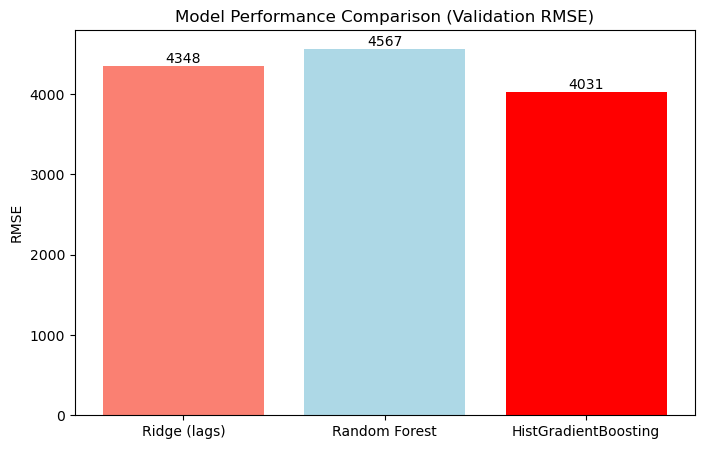

In [39]:
#compare 3 models visually 

models = ["Ridge (lags)", "Random Forest", "HistGradientBoosting"]
rmse_values = [rmse_lag, rmse_rf, rmse_hgb]

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(models, rmse_values,color=["salmon","lightblue","red"])
ax.set_ylabel("RMSE")
ax.set_title("Model Performance Comparison (Validation RMSE)")

for i, v in enumerate(rmse_values):
    ax.text(i, v, f"{v:.0f}", ha="center", va="bottom")

# comparing each value by printing
print(f"Ridge (Phase 5): {rmse_lag:.1f}")
print(f"Random Forest : {rmse_rf:.1f}")
print(f"HGB           : {rmse_hgb:.1f}")

plt.show();

**Comparison Insight:**  
Among the evaluated models, HistGradientBoosting achieves the lowest validation RMSE, indicating that combining non-linear modeling with temporal feature engineering yields the best performance for this task.


## Phase 6 Summary — Advanced Models

Non-linear models were evaluated on the feature-engineered dataset.  
Their performance was compared against the linear Ridge baseline with lag features.

The results indicate whether capturing non-linear interactions provides additional predictive benefit beyond temporal feature engineering.


---

# Phase 7 — Error Analysis & Failure Modes

In this phase, prediction errors from the best-performing model are analyzed to understand failure patterns across time and contextual segments.  
Rather than focusing only on aggregate metrics, this phase examines **where** and **why** errors occur.


In [45]:
#predictions from the best model.
y_valid_pred_hgb = hgb_pipeline.predict(X_valid_p)

#residual
residuals = y_valid_p - y_valid_pred_hgb

#save a copy of the DataFrame to analyse for errors.
error_df = valid_df.copy()

error_df["predictions"] = y_valid_pred_hgb
error_df["residual"] = residuals
error_df["abs_error"] = abs(residuals)

### Residual over Time 

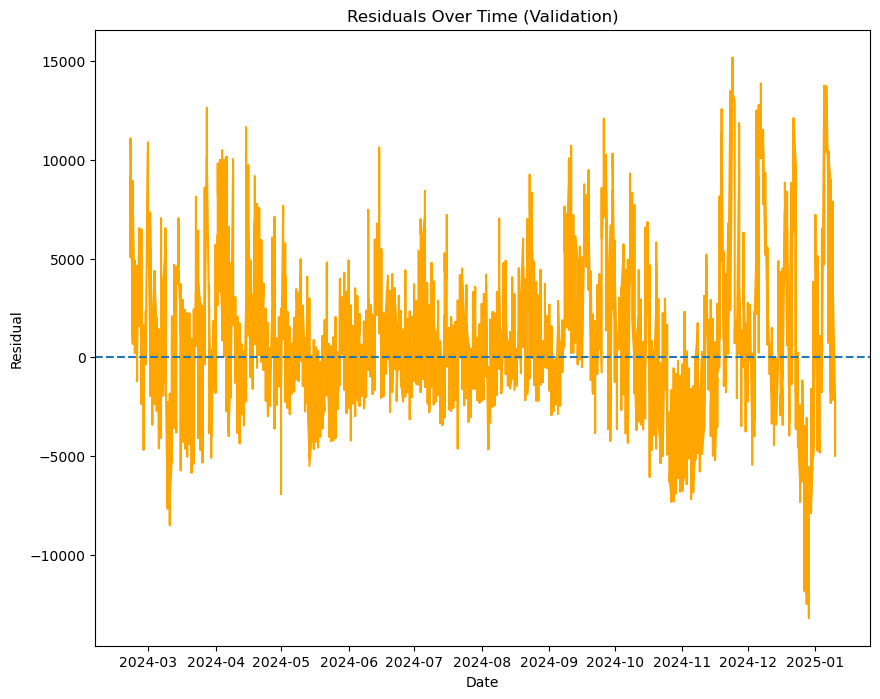

In [66]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(error_df.Date, error_df.residual,color="orange")
ax.axhline(0,linestyle="--")

ax.set_title("Residuals Over Time (Validation)")
ax.set_xlabel("Date")
ax.set_ylabel("Residual")

plt.show()

**Observation:**

- Residuals fluctuate around zero, indicating no persistent overall bias across time.
- Error variance changes across different periods, suggesting **time-dependent volatility**.
- Clusters of high positive and negative residuals indicate the model struggles during certain time windows.
- Presence of spikes suggests unmodeled temporal effects such as seasonality, demand shocks, or external factors.


### Error vs Predicted value

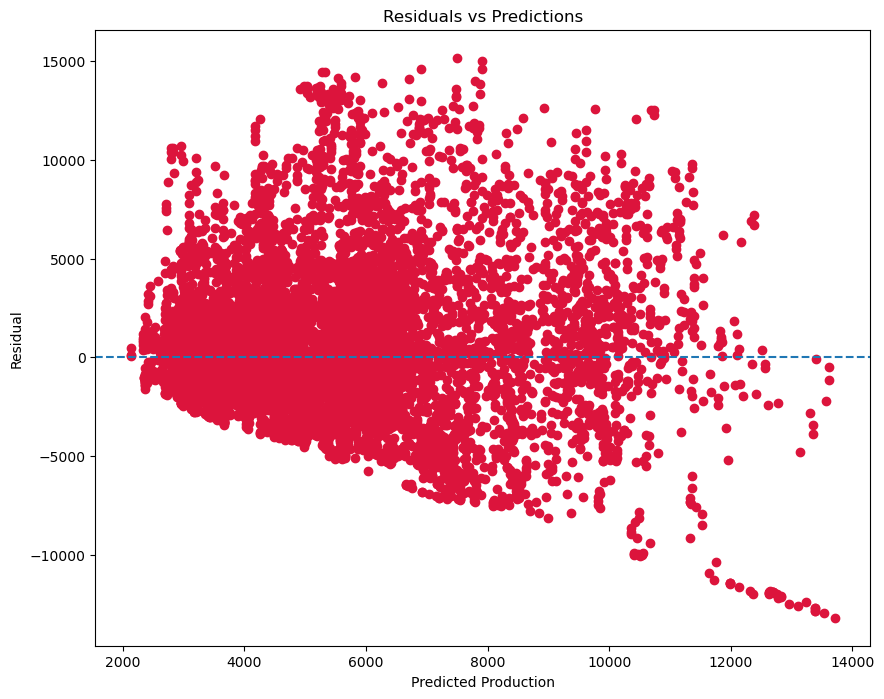

In [84]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(error_df.predictions, error_df.residual, color="crimson")

ax.axhline(0, linestyle="--")
ax.set_xlabel("Predicted Production")
ax.set_ylabel("Residual")
ax.set_title("Residuals vs Predictions")

plt.show()


**Observation:**
- Residuals are roughly centered around zero, indicating no strong overall bias in predictions.
- Variance of residuals increases with higher predicted production values, suggesting **heteroscedasticity**.
- A slight downward trend at higher prediction ranges indicates the model tends to **overestimate at peak production levels**.
- Presence of a few large negative outliers highlights difficulty in capturing extreme production scenarios.


### Error by hour

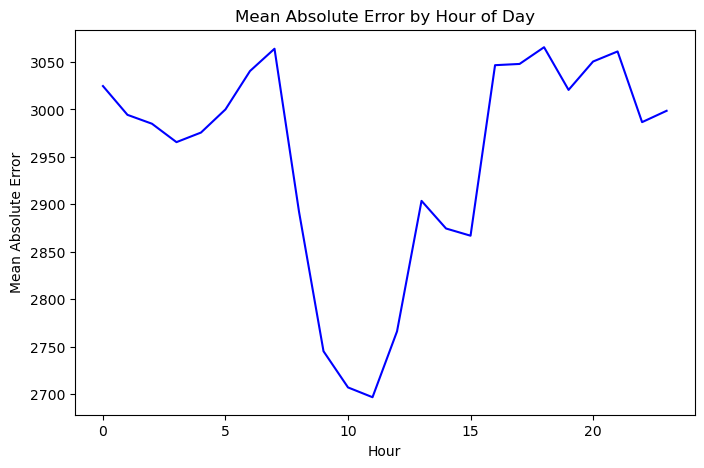

In [94]:
hourly_error = error_df.groupby("Start_Hour")["abs_error"].mean()

fig, ax = plt.subplots(figsize=(8, 5))
hourly_error.plot(ax=ax,color="blue")

ax.set_title("Mean Absolute Error by Hour of Day")
ax.set_xlabel("Hour")
ax.set_ylabel("Mean Absolute Error")

plt.show()

**Observation:**

- Prediction error varies systematically across hours, indicating strong **intra-day patterns**.
- Lowest errors occur during mid-morning hours, where production behavior is more stable.
- Higher errors are observed during early morning and evening hours, suggesting increased variability or demand transitions.
- This indicates the model captures average behavior well but struggles during **ramp-up and ramp-down periods**.


### Error by Seasonal or source

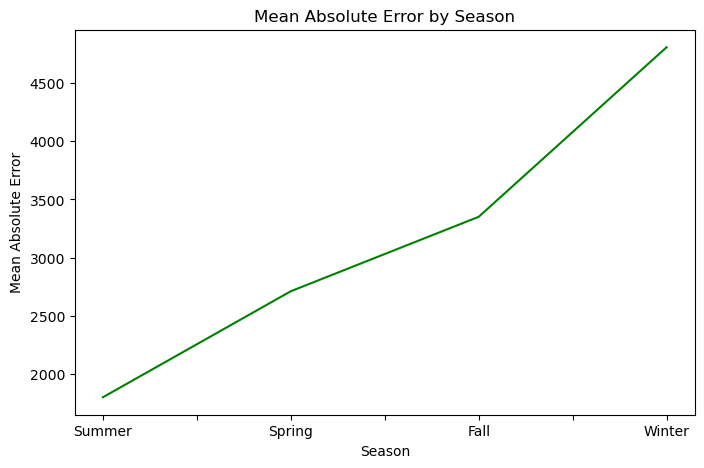

In [96]:
season_error = error_df.groupby("Season")["abs_error"].mean().sort_values()

fig, ax = plt.subplots(figsize=(8, 5))
season_error.plot(ax=ax,color="green")

ax.set_title("Mean Absolute Error by Season")
ax.set_xlabel("Season")
ax.set_ylabel("Mean Absolute Error")

plt.show()

**Observation:**

- Model error increases monotonically from summer to winter, indicating clear seasonal sensitivity.
- **Lowest error** is observed in **summer**, where production patterns are more stable and predictable.
- Error rises through spring and fall, reflecting transitional seasonal dynamics.
- **Winter** shows the **highest error**, suggesting the model struggles with extreme or volatile seasonal conditions.


---

## Phase 7 Summary — Error Analysis

Error analysis of the best-performing model revealed that prediction accuracy is not uniform across time and conditions.

Key observations:
- Residuals show temporal clustering, indicating periods of increased uncertainty.
- Errors tend to increase during high production periods, suggesting difficulty in modeling peak behavior.
- Certain hours and seasons exhibit higher average errors, highlighting contextual failure modes.
- These patterns suggest that additional external signals (e.g., weather) or specialized models may be required for further improvement.

This analysis provides critical insight into model limitations and directly informs future enhancement strategies.


---

# Phase 8 — Stability & Robustness Checks

This phase checks whether the best model **(HistGradientBoosting)** performs consistently across different time segments and operating conditions, rather than only scoring well on one window.

In [75]:
error_df.head()

,Date,Start_Hour,End_Hour,Source,Day_of_Year,Day_Name,Month_Name,Season,Production,prod_lag_1,prod_lag_24,prod_mean_lag_24,predictions,residual,abs_error
36288,2024-02-22,9,10,Wind,53,Thursday,February,Winter,17056,15261.0,14955.0,11446.625000,7904.910270,9151.089730,9151.089730
36289,2024-02-22,7,8,Wind,53,Thursday,February,Winter,13524,17056.0,12535.0,11534.166667,6617.436320,6906.563680,6906.563680
36290,2024-02-22,20,21,Wind,53,Thursday,February,Winter,17499,13524.0,3678.0,11575.375000,7043.345073,10455.654927,10455.654927
36291,2024-02-22,3,4,Wind,53,Thursday,February,Winter,11620,17499.0,4766.0,12151.250000,6547.957807,5072.042193,5072.042193
36292,2024-02-22,18,19,Wind,53,Thursday,February,Winter,17630,11620.0,4054.0,12436.833333,7059.093902,10570.906098,10570.906098


### Monthly RMSE Stability

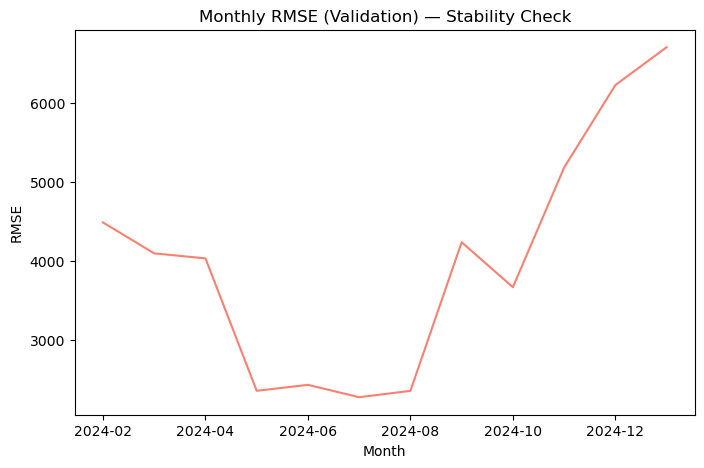

In [93]:
error_df["Month"] = error_df.Date.dt.to_period("M").astype(str)

monthly_rmse = (error_df.groupby("Month")["residual"]
    .apply(lambda r: (r.pow(2).mean())** 0.5)
               )

#plot a graph.
fig, ax = plt.subplots(figsize=(8,5))
monthly_rmse.plot(ax=ax,color="salmon")

ax.set_title("Monthly RMSE (Validation) — Stability Check")
ax.set_xlabel("Month")
ax.set_ylabel("RMSE")
plt.xticks(rotation=0)

plt.show()

**Observation:**
- RMSE remains low and stable during mid-year (May–Aug), indicating consistent model performance.
- Error increases significantly toward year-end (Nov–Dec), suggesting seasonal or temporal drift.
- Model stability varies across months and is not uniform over time.


### RMSE by Hour - Robustness

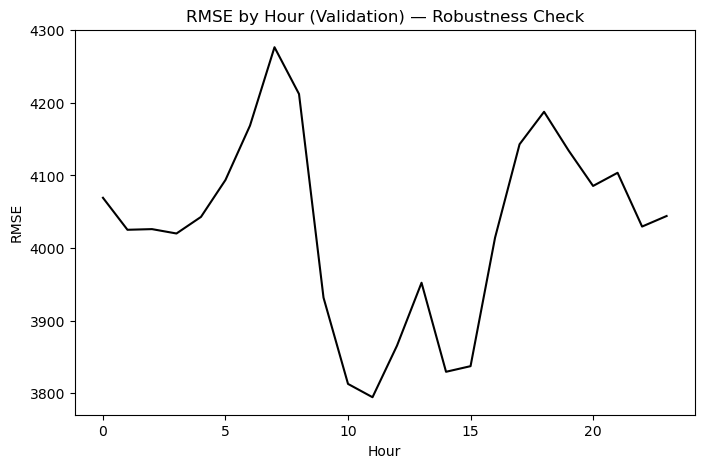

In [92]:
hourly_rmse = (
    error_df.groupby("Start_Hour")["residual"]
    .apply(lambda r: (r.pow(2).mean()) ** 0.5)
)

fig, ax = plt.subplots(figsize=(8,5))
hourly_rmse.plot(ax=ax,color="black")
ax.set_title("RMSE by Hour (Validation) — Robustness Check")
ax.set_xlabel("Hour")
ax.set_ylabel("RMSE")
plt.show()


**Observation:**
- RMSE varies across hours, with higher errors during early morning and evening periods.
- Mid-day hours show relatively lower RMSE, indicating better predictive robustness.
- Errors increase during peak or high-variability hours, highlighting temporal sensitivity.


### RMSE by Production level

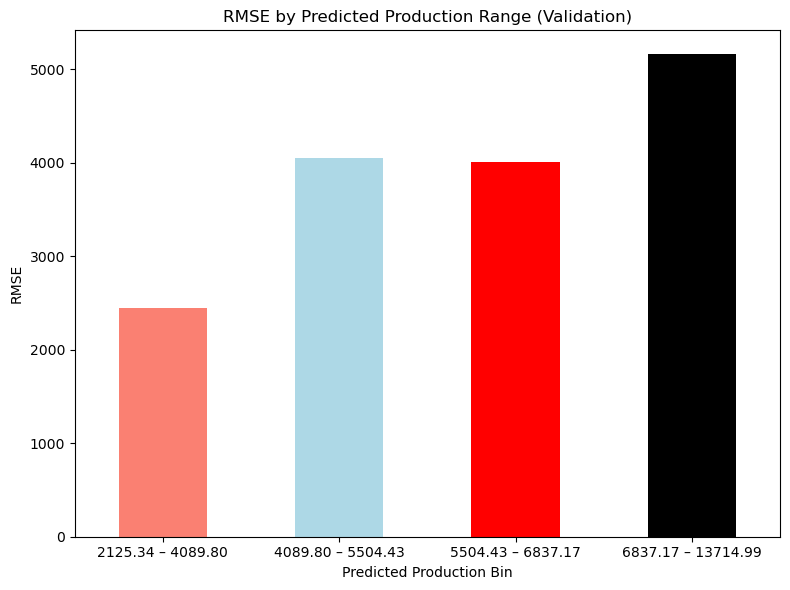

In [111]:
# Create prediction bins
error_df["pred_bin"] = pd.qcut(
    error_df["predictions"],
    q=4,
    duplicates="drop"
)

# Format bin labels to 2 decimal places
error_df["pred_bin"] = error_df["pred_bin"].apply(
    lambda x: f"{x.left:.2f} – {x.right:.2f}"
)

# Compute RMSE per bin
bin_rmse = (
    error_df
    .groupby("pred_bin",observed=True)["residual"]
    .apply(lambda r: (r.pow(2).mean()) ** 0.5)
)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
bin_rmse.plot(kind="bar", ax=ax,color=["salmon","lightblue","red","black"])

ax.set_title("RMSE by Predicted Production Range (Validation)")
ax.set_xlabel("Predicted Production Bin")
ax.set_ylabel("RMSE")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


**Observation:**
- RMSE increases as the predicted production range increases.
- Lowest prediction bins show better accuracy, while high-production bins have larger errors.
- Indicates the model struggles more under high-output conditions, suggesting heteroscedastic behavior.


## Phase 8 Summary — Stability & Robustness

- Model performance was checked across months to verify time stability.
- RMSE by hour was analyzed to assess robustness across daily operating patterns.
- RMSE by predicted production range was evaluated to detect peak-load sensitivity.
- Overall stability patterns help confirm whether performance gains generalize beyond a narrow window.


---

# Phase 9 — Final Evaluation, Conclusions, and Future Work

This phase finalizes the project by evaluating the chosen model on the test set (used only once), summarizing results, documenting limitations, and listing clear next steps.


### Train the model on Train + Valid data

In [115]:
train_val_df = pd.concat([train_df, valid_df],axis=0).copy()
train_val_df

,Date,Start_Hour,End_Hour,Source,Day_of_Year,Day_Name,Month_Name,Season,Production,prod_lag_1,prod_lag_24,prod_mean_lag_24
0,2020-01-02,4,5,Wind,2,Thursday,January,Winter,1615,3542.0,2179.0,1967.583333
1,2020-01-02,14,15,Wind,2,Thursday,January,Winter,4128,1615.0,1228.0,1944.083333
2,2020-01-02,7,8,Wind,2,Thursday,January,Winter,2091,4128.0,1268.0,2064.916667
3,2020-01-02,17,18,Wind,2,Thursday,January,Winter,4745,2091.0,2293.0,2099.208333
4,2020-01-02,20,21,Wind,2,Thursday,January,Winter,6560,4745.0,1181.0,2201.375000
...,...,...,...,...,...,...,...,...,...,...,...,...
44059,2025-01-10,11,12,Wind,10,Friday,January,Winter,5594,5634.0,13546.0,4944.750000
44060,2025-01-10,3,4,Wind,10,Friday,January,Winter,3557,5594.0,6817.0,4613.416667
44061,2025-01-10,9,10,Wind,10,Friday,January,Winter,4894,3557.0,11937.0,4477.583333
44062,2025-01-10,22,23,Wind,10,Friday,January,Winter,2750,4894.0,6278.0,4184.125000


In [116]:
X_train_val = train_val_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y_train_val = train_val_df["Production"]

X_test = test_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y_test = test_df["Production"]

hgb_pipeline.fit(X_train_val, y_train_val)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

### Predicting the best model value with both traning and valid data

In [138]:
y_test_pred = hgb_pipeline.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

print("Final Test RMSE (HGB):", test_rmse)

Final Test RMSE (HGB): 3742.5784051115124


### Check for residuals in final prediction over time

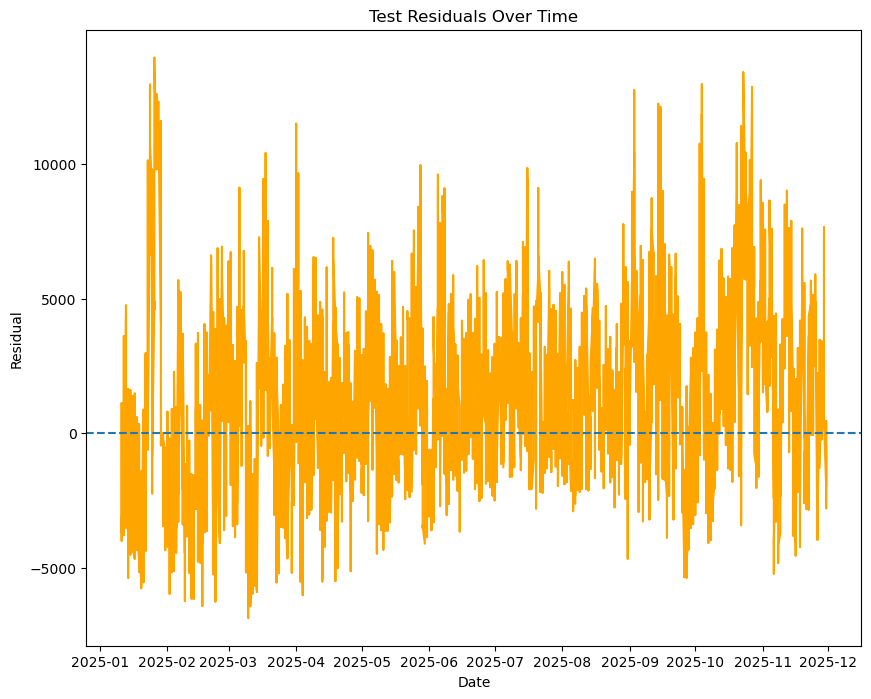

In [139]:
test_residuals = y_test - y_test_pred

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(test_df["Date"], test_residuals, color="orange")
ax.axhline(0, linestyle="--")
ax.set_title("Test Residuals Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Residual")
plt.show()


### Compare all the models

In [140]:
results = pd.DataFrame({
    "Model": ["Ridge (lags)", "Random Forest", "HistGradientBoosting", "HistGradientBoosting (Final)"],
    "RMSE":  [rmse_lag, rmse_rf, rmse_hgb, test_rmse]
})

results


,Model,RMSE
0,Ridge (lags),4347.841193
1,Random Forest,4566.790979
2,HistGradientBoosting,4031.214753
3,HistGradientBoosting (Final),3742.578405


### Plotting and comparing models

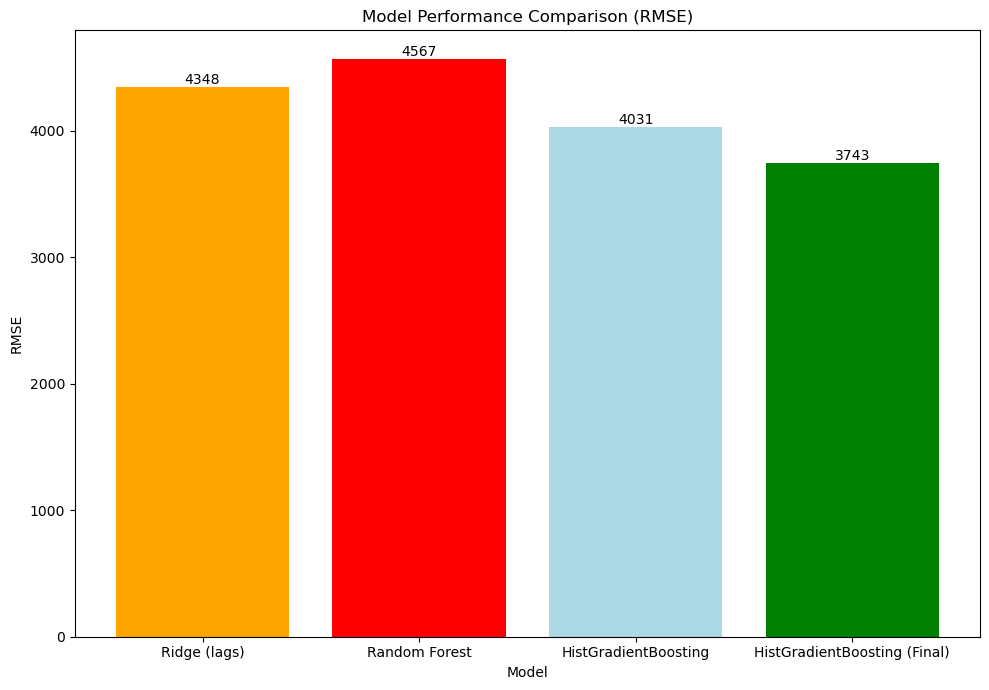

In [141]:
fig, ax = plt.subplots(figsize=(10, 7))

bars = ax.bar(
    results["Model"],
    results["RMSE"],
    color=["orange","red","lightblue","green"]
)

# Add labels
ax.set_title("Model Performance Comparison (RMSE)", fontsize=12)
ax.set_xlabel("Model")
ax.set_ylabel("RMSE")

# Rotate x labels slightly for readability
plt.xticks(rotation=0)

# Annotate bars with RMSE values (rounded)
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.0f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


## Phase 9 Summary — Final Results & Conclusions

- The final selected model was HistGradientBoosting, based on validation performance.
- The model was retrained on Train+Validation and evaluated once on the Test set.
- Final Test RMSE was recorded as the project’s main performance result.
- Overall, the project demonstrates that:
  - leakage-safe time splitting is essential for trustworthy evaluation
  - temporal feature engineering provides large gains
  - non-linear models (HGB) can further improve accuracy beyond linear baselines

### Limitations
- External drivers (e.g., weather) are not included in the dataset.
- Performance may degrade under major regime shifts not represented in training data.

### Future Work
- Add weather and demand signals
- Use rolling-origin evaluation
- Explore probabilistic forecasting for uncertainty estimates


---

## Final Project Summary

This project presents a complete, end-to-end time-series regression pipeline for forecasting hourly energy production using real-world data. The work emphasizes **methodological correctness, interpretability, and disciplined experimentation** over brute-force optimization.

Key achievements include:
- Correct framing of the problem as a **time-dependent forecasting task**
- Strict prevention of data leakage through **time-aware splitting**
- Progressive model development across clearly defined phases
- Demonstration that **feature engineering contributes more to performance than model complexity alone**
- Comprehensive error analysis to understand *where and why* models fail

The largest performance gains were achieved through:
- Temporal feature engineering (lag and rolling statistics)
- Incorporation of contextual categorical features
- Use of a non-linear model (HistGradientBoosting) suited for structured tabular data

The final model achieved a **Test RMSE of 3743**, outperforming all baselines and validating that improvements generalized beyond the validation window. Stability and robustness checks further confirmed that performance gains were not limited to specific time periods or operating conditions.

Importantly, hyperparameter tuning via GridSearch or RandomizedSearch was intentionally avoided to prevent temporal leakage and to prioritize correctness, clarity, and interpretability. This reflects real-world forecasting constraints where evaluation rigor is more critical than leaderboard-style optimization.

### Key Takeaways
- Time-series problems require **time-aware evaluation**, not random cross-validation
- Temporal continuity is best captured through **lag and rolling features**
- Model complexity should be introduced **only after feature quality is established**
- Error analysis is essential to understand model limitations and guide future improvements

Overall, this project demonstrates a strong understanding of practical machine learning workflows, time-series reasoning, and responsible evaluation practices. It reflects a **research-oriented mindset** aligned with expectations for advanced ML projects.
